In [1]:
# In this notebook, we will be focusing on building an image classification model using neural networks, we will be using the fashionMNST dataset
import numpy as np
import time
import torch
import torchvision
from torchvision import transforms
from d2l import torch as d2l

In [6]:
# Since fasion MNST is such a popular dataset, it usually comes preloaded in most deep learning frameworks

class FashionMNST(d2l.DataModule):
    
    def __init__(self, batch_size = 64, resize = (28, 28),*args,**kwargs):
        super().__init__(*args,**kwargs)
        self.save_hyperparameters()
        trans  = transforms.Compose([transforms.Resize(resize), transforms.ToTensor()])
        self.train = torchvision.datasets.FashionMNIST(root=self.root, train=True, transform=trans, download=True)
        self.val = torchvision.datasets.FashionMNIST(root=self.root, train=False, transform=trans, download=True)

In [7]:
# analysing the fashion MNST dataset
data = FashionMNST(resize=(32,32))
len(data.train), len(data.val)

1.6%

100.0%


Extracting ../data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ../data/FashionMNIST/raw



100.0%
0.7%

Extracting ../data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ../data/FashionMNIST/raw



100.0%


Extracting ../data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ../data/FashionMNIST/raw



100.0%

Extracting ../data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/FashionMNIST/raw



(60000, 10000)

In [12]:
# In this case, the image on the dataset has only one channel, must must times images have 3 channels (R, G, B). Although 
# Hyperscale images can have up to 100s of channels. The tensor formula is c * h * w, where c is the number of channels
# h is the height of the image, w is the width of the image.

data.train[0][0].shape, data.train[0][1],

(torch.Size([1, 32, 32]), 9)

In [16]:
@d2l.add_to_class(FashionMNST)
def text_lables(self, indices):
    # get the tex labels for particular indices of y
    labels = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat',
              'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']
    
    return [labels[int(i)] for i in indices]

In [17]:
@d2l.add_to_class(FashionMNST)
def get_dataloader(self, train):
    data = self.train if train else self.val
    return torch.utils.data.DataLoader(data, self.batch_size, shuffle=train, num_workers=self.num_workers)

In [18]:
X, y = next(iter(data.train_dataloader()))
print(X.shape, X.dtype, y.shape, y.dtype)

torch.Size([64, 1, 32, 32]) torch.float32 torch.Size([64]) torch.int64


In [19]:
tic = time.time()
for X, y in data.train_dataloader():
    continue
f'{time.time() - tic:.2f} sec'

'2.45 sec'

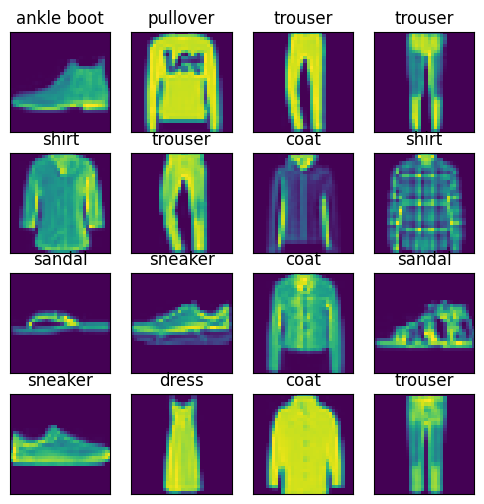

In [21]:
@d2l.add_to_class(FashionMNST)  #@save
def visualize(self, batch, nrows=4, ncols=4, labels=[]):
    X, y = batch
    if not labels:
        labels = self.text_lables(y)
    d2l.show_images(X.squeeze(1), nrows, ncols, titles=labels)
batch = next(iter(data.val_dataloader()))
data.visualize(batch)

In [22]:
# Building the basic classification model
class Classifier(d2l.Module):
    def validation_step(self, batch):
        y_hat = self(*batch[:-1])
        self.plot('loss', self.loss(y_hat, batch[-1]), train=False)
        self.plot('acc', self.accuracy(y_hat, batch[-1]), train=False)
        
    def configure_optimizers(self):
        return torch.optim.SGD(self.parameters(), lr=self.lr)
    
    def accuracy(self, Y_hat, Y, averaged=True):
        """Compute the number of correct predictions."""
        Y_hat = Y_hat.reshape((-1, Y_hat.shape[-1]))
        preds = Y_hat.argmax(axis=1).type(Y.dtype)
        compare = (preds == Y.reshape(-1)).type(torch.float32)
        return compare.mean() if averaged else compare
    

In [23]:
X = torch.tensor([[1, 2, 3], [4, 5, 6]])
X.sum(0, keepdims=True), X.sum(1, keepdims=True)

(tensor([[5, 7, 9]]),
 tensor([[ 6],
         [15]]))

In [24]:
def softmax(X):
    X_exp = torch.exp(X)
    partition = X_exp.sum(1, keepdims=True)
    return X_exp / partition  # The broadcasting mechanism is applied here

In [25]:
X = torch.rand((2, 5))
X_prob = softmax(X)
X_prob, X_prob.sum(1)

(tensor([[0.1583, 0.1220, 0.2492, 0.2622, 0.2083],
         [0.1840, 0.1909, 0.1380, 0.2169, 0.2702]]),
 tensor([1.0000, 1.0000]))

In [28]:
X = torch.randn((2, 5))
X

tensor([[-0.1756,  0.2850,  0.7678,  0.4807, -0.4194],
        [ 1.0163,  1.1526,  0.3742,  1.8613, -1.1409]])

In [34]:
X = X.reshape((-1, 10))
X

tensor([[-0.1756,  0.2850,  0.7678,  0.4807, -0.4194,  1.0163,  1.1526,  0.3742,
          1.8613, -1.1409]])

In [47]:
from torch import nn
from torch.nn import functional as F

class SoftMaxRegression(d2l.Classifier):
    def __init__(self, num_outputs,lr, sigma =0.1,*args, **kwargs):
        def __init__(self, num_outputs, lr):
            super().__init__()
            self.save_hyperparameters()
            self.net = nn.Sequential(nn.Flatten(),
                                    nn.LazyLinear(num_outputs))

    
    def forward(self, X):
        return self.net(X)


In [48]:
# cross entropy loss function might be the most common loss function in all of deep learning
def cross_entropy(y_hat, y):
    return -torch.log(y_hat[list(range(len(y_hat))), y]).mean()

In [49]:
d2l.add_to_class(SoftMaxRegression)
def loss(self, y_hat, y, averaged=True):
    y_hat = y_hat.reshape((-1, y_hat.shape[-1]))
    y = y.reshape((-1,))
    return F.cross_entropy(
        y_hat, y, reduction='mean' if averaged else 'none')

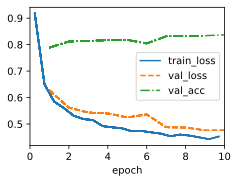

In [51]:
# now for the training step
data = FashionMNST(batch_size=256)
model = d2l.SoftmaxRegression(num_outputs=10, lr=0.1)
trainer = d2l.Trainer(max_epochs=10)
trainer.fit(model, data)

In [52]:
X, y  = next(iter(data.val_dataloader()))
preds = model(X).argmax(axis = 1)
preds.shape

torch.Size([256])

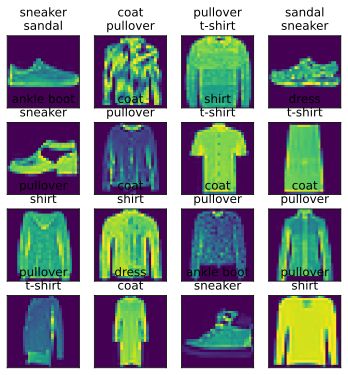

In [55]:
wrong = preds.type(y.dtype) != y
X, y, preds = X[wrong], y[wrong], preds[wrong]
labels = [a+'\n'+b for a, b in zip(
    data.text_lables(y), data.text_lables(preds))]
data.visualize([X, y], labels=labels)